In [38]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False, 'xtick.bottom': True, 'ytick.left': True, })

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
import visual_behavior.data_access.loading as loading

In [4]:
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

In [5]:
import visual_behavior_glm.GLM_params as glm_params
import visual_behavior_glm.GLM_analysis_tools as gat

In [6]:
import mindscope_utilities.general_utilities as ms_utils
import mindscope_utilities.visual_behavior_ophys.data_formatting as vb_ophys

import visual_behavior.visualization.utils as utils


### get cache and expts table 

In [7]:
cache_dir = loading.get_platform_analysis_cache_dir()
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir)

In [8]:
experiments_table = loading.get_platform_paper_experiment_table()

In [9]:
experiment_id = experiments_table.index.values[10]
dataset = cache.get_behavior_ophys_experiment(experiment_id)

### load GLM weights and dropout scores for version 20 with events

In [10]:
run_params = glm_params.load_run_json('20_events_all_L2_optimize_by_session')
results_pivoted = gat.build_pivoted_results_summary('adj_fraction_change_from_full', glm_version=run_params['version'])
weights_df = gat.build_weights_df(run_params, results_pivoted)
len(weights_df)

100%|██████████████████████████████████████████████████████████████████████████████| 1248/1248 [03:20<00:00,  6.24it/s]


2033890

#### drop duplicates, create 'identifier' column similar to in results_pivoted, then set identifier as index

In [11]:
weights_df = weights_df.drop_duplicates(subset=['cell_specimen_id', 'ophys_experiment_id'])
weights_df = weights_df.reset_index()
weights_df['identifier'] = [str(weights_df.iloc[row]['ophys_experiment_id'])+'_'+str(weights_df.iloc[row]['cell_specimen_id']) for row in range(len(weights_df))]
weights_df = weights_df.set_index('identifier')
len(weights_df)

77738

In [43]:
results_pivoted = results_pivoted.drop_duplicates(subset=['cell_specimen_id', 'ophys_experiment_id'])
results_pivoted = results_pivoted.reset_index()
# results_pivoted = results_pivoted.set_index('identifier')
len(results_pivoted)

77738

#### get kernel params

In [12]:
kernels = gat.glm_params.define_kernels()
kernels['licks']

{'event': 'licks',
 'type': 'discrete',
 'length': 4,
 'offset': -2,
 'num_weights': None,
 'dropout': True,
 'text': 'mouse lick'}

How can i be sure that these params are correct for version 20?

### Plot weights for one cell for lick kernel

In [14]:
# get cells with high lick dropout
examples = results_pivoted[results_pivoted.licks<-0.7]

In [15]:
examples[['licks', 'running', 'behavioral']]

licks   running  behavioral
194064  -0.893583 -0.207783   -0.247324
194065  -0.893583 -0.207783   -0.247324
194066  -0.893583 -0.207783   -0.247324
194067  -0.893583 -0.207783   -0.247324
194068  -0.893583 -0.207783   -0.247324
...           ...       ...         ...
2009618 -0.914006 -0.365941    0.000000
2009619 -0.914006 -0.365941    0.000000
2009620 -0.914006 -0.365941    0.000000
2009621 -0.914006 -0.365941    0.000000
2009622 -0.914006 -0.365941    0.000000

[1714 rows x 3 columns]

Why is the behavioral dropout zero in cases where the lick dropout is so high? 

Text(0, 0.5, 'weight')

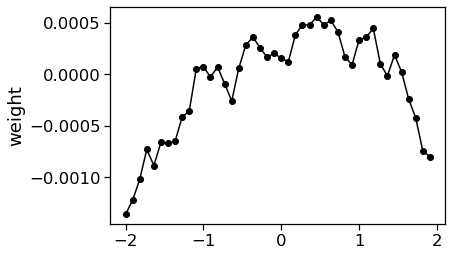

In [17]:
# get examples with high lick dropout
examples = results_pivoted[results_pivoted.licks<-0.7]
identifiers = examples.identifier.unique()

identifier = identifiers[0]

if 'MESO' in weights_df.loc[identifier]['equipment_name']:
    frame_rate = 11.
else:
    frame_rate = 31.

time_window = (kernels['licks']['offset'], kernels['licks']['offset']+kernels['licks']['length'])
t_array = ms_utils.get_time_array(t_start=time_window[0], t_end=time_window[1], sampling_rate=frame_rate, include_endpoint=False,)


plt.plot(t_array, weights_df.loc[identifier]['licks_weights'],'ko-')
plt.ylabel('weight')

Why is the licks dropout score so high when the weights are pretty low? 

### Plot lick triggered average trace with mindscope_utilities

In [18]:
dataset = cache.get_behavior_ophys_experiment(experiment_id)

In [19]:
tidy_cell_df = vb_ophys.build_tidy_cell_df(dataset)

In [20]:
tidy_cell_df.tail()

timestamps       dff  events  filtered_events cell_roi_id  \
140071  4530.44632  0.130990     0.0              0.0  1080921430   
140072  4530.47864  0.025878     0.0              0.0  1080921430   
140073  4530.51097  0.118974     0.0              0.0  1080921430   
140074  4530.54329  0.120523     0.0              0.0  1080921430   
140075  4530.57562  0.132623     0.0              0.0  1080921430   

       cell_specimen_id  
140071       1086518772  
140072       1086518772  
140073       1086518772  
140074       1086518772  
140075       1086518772

In [21]:
cell_specimen_ids = tidy_cell_df.cell_specimen_id.unique()
cell_specimen_id = cell_specimen_ids[0]

#### tidy version

In [22]:
event_times = dataset.licks.timestamps
data = tidy_cell_df[tidy_cell_df.cell_specimen_id==cell_specimen_id]

etr = ms_utils.event_triggered_response(data, t='timestamps', y='filtered_events', event_times=event_times, 
                                        t_start=-1, t_end=1, output_format='tidy', 
                                        output_sampling_rate=None, interpolate=False)
   
etr['cell_specimen_id'] = cell_specimen_id

In [23]:
etr.head()

time       dff  event_number  original_index  event_time  \
0 -0.969675  0.071369             0               0     8.37072   
1 -0.937353  0.221828             0               0     8.37072   
2 -0.905030  0.134924             0               0     8.37072   
3 -0.872708 -0.005556             0               0     8.37072   
4 -0.840385  0.017979             0               0     8.37072   

   cell_specimen_id  
0        1086491394  
1        1086491394  
2        1086491394  
3        1086491394  
4        1086491394

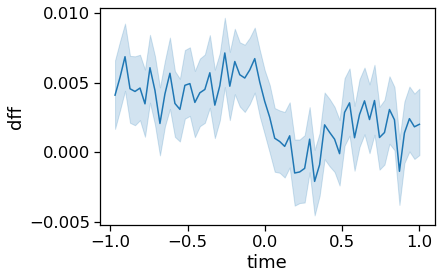

In [24]:
sns.lineplot(data=etr, x='time', y='dff')

#### wide version

In [26]:
event_times = dataset.licks.timestamps
data = tidy_cell_df[tidy_cell_df.cell_specimen_id==cell_specimen_id]

etr = ms_utils.event_triggered_response(data, t='timestamps', y='dff', event_times=event_times, 
                                        t_start=-1, t_end=1, output_format='wide', include_endpoint=False,
                                        output_sampling_rate=31, interpolate=True)
   

In [27]:
etr.head()

event_0_t=8.37072  event_1_t=8.48713  event_2_t=12.12342  \
time                                                                  
-1.000000           0.071369          -0.005556            0.142777   
-0.967742           0.101759           0.013361            0.084089   
-0.935484           0.204441           0.124893            0.041226   
-0.903226           0.107088           0.121085            0.147396   
-0.870968          -0.000937           0.086346            0.036289   

           event_3_t=16.97739  event_4_t=17.26095  event_5_t=20.94728  \
time                                                                    
-1.000000           -0.072620            0.103375           -0.002441   
-0.967742           -0.032284            0.061619           -0.069073   
-0.935484           -0.018652           -0.027461           -0.145482   
-0.903226            0.028365            0.009946           -0.021867   
-0.870968            0.128953           -0.011438            0.004887   

           event_6_t=27.3191  event_7_t=27.51926  event_8_t=27.75289  \
time                                                                   
-1.000000          -0.075307            0.010611           -0.101332   
-0.967742          -0.040061           -0.044614           -0.007078   
-0.935484           0.079301            0.070364            0.110790   
-0.903226           0.115041            0.030853            0.084018   
-0.870968           0.002107           -0.076921           -0.022069   

           event_9_t=28.11986  ...  event_3622_t=4286.82785  \
time                           ...                            
-1.000000            0.015299  ...                 0.048571   
-0.967742            0.000360  ...                 0.007659   
-0.935484           -0.008586  ...                 0.015608   
-0.903226            0.083395  ...                 0.140065   
-0.870968            0.096830  ...                 0.100582   

           event_3623_t=4287.24486  event_3624_t=4287.46166  \
time                                                          
-1.000000                -0.011456                 0.122463   
-0.967742                 0.023921                -0.022221   
-0.935484                 0.062814                -0.050936   
-0.903226                -0.092999                -0.085785   
-0.870968                -0.003713                -0.057836   

           event_3625_t=4287.76199  event_3626_t=4289.07966  \
time                                                          
-1.000000                -0.101667                -0.028561   
-0.967742                -0.105073                -0.024529   
-0.935484                -0.075850                 0.158849   
-0.903226                 0.061409                 0.192666   
-0.870968                 0.083847                 0.196731   

           event_3627_t=4294.56744  event_3628_t=4295.68505  \
time                                                          
-1.000000                 0.020506                 0.027874   
-0.967742                -0.076773                 0.022225   
-0.935484                -0.029490                -0.005141   
-0.903226                 0.054191                 0.000892   
-0.870968                -0.038326                 0.038987   

           event_3629_t=4298.00364  event_3630_t=4298.95444  \
time                                                          
-1.000000                 0.058986                 0.034843   
-0.967742                 0.057462                 0.028164   
-0.935484                 0.039320                -0.010618   
-0.903226                -0.002844                -0.058412   
-0.870968                -0.028992                -0.088085   

           event_3631_t=4299.73834  
time                                
-1.000000                 0.115279  
-0.967742                 0.044377  
-0.935484                 0.027079  
-0.903226                -0.056812  
-0.870968                -0.095586  

[5 rows x 3632 columns]

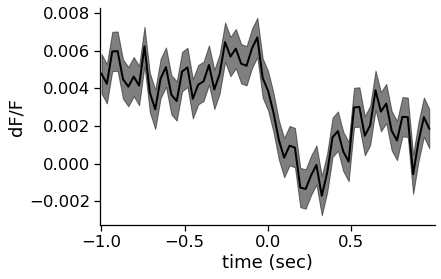

In [28]:
import visual_behavior.visualization.utils as utils

traces = etr.T.values
timestamps = etr.index.values

utils.plot_mean_trace(traces, timestamps, ylabel='dF/F', legend_label=None, color='k', interval_sec=0.5, xlim_seconds=[-1.01,1],
                    plot_sem=True, ax=None)

### Plot GLM weights and traces for example cells

In [29]:
def get_etr_for_cell_specimen_id(dataset, cell_specimen_id, y, event_times, time_window=[-1,1], frame_rate=11):
    tidy_cell_df = vb_ophys.build_tidy_cell_df(dataset)
    data = tidy_cell_df[tidy_cell_df.cell_specimen_id==cell_specimen_id]

    etr = ms_utils.event_triggered_response(data, t='timestamps', y=y, event_times=event_times, 
                                        t_start=time_window[0], t_end=time_window[1], output_format='wide', 
                                        include_endpoint=False, output_sampling_rate=frame_rate, interpolate=True)
    return etr


def plot_etr_trace_for_cell_specimen_id(dataset, cell_specimen_id, y, event_times, time_window=[-1,1], frame_rate=11, ax=None):
    etr = get_etr_for_cell_specimen_id(dataset, cell_specimen_id, y, event_times, time_window, frame_rate)

    traces = etr.T.values
    timestamps = etr.index.values

    utils.plot_mean_trace(traces, timestamps, ylabel=y, legend_label=None, color='k', 
                          interval_sec=1, xlim_seconds=time_window, plot_sem=True, ax=ax)
    return ax

In [30]:
# get cells with high lick dropouts
examples = results_pivoted[results_pivoted.licks<-0.7]

In [31]:
save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\GLM_examples'

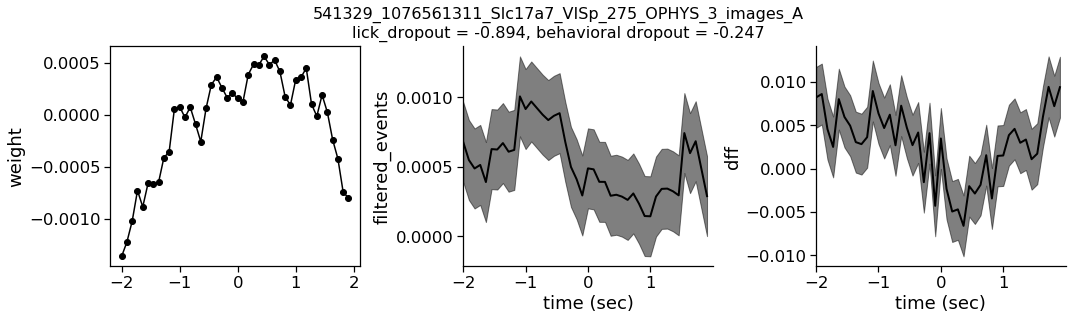

In [37]:
example = examples.iloc[0]

identifier = example.identifier
cell_specimen_id = example.cell_specimen_id
ophys_experiment_id = example.ophys_experiment_id

dataset = cache.get_behavior_ophys_experiment(ophys_experiment_id)
event_times = dataset.licks.timestamps
y = 'dff'

if 'MESO' in weights_df.loc[identifier]['equipment_name']:
    frame_rate = 11.
else:
    frame_rate = 31.

time_window = (kernels['licks']['offset'], kernels['licks']['offset']+kernels['licks']['length'])
t_array = ms_utils.get_time_array(t_start=time_window[0], t_end=time_window[1], sampling_rate=frame_rate, include_endpoint=False,)

figsize=(15,4)
fig, ax = plt.subplots(1, 3, figsize=figsize)
ax = ax.ravel()
ax[0].plot(t_array, weights_df.loc[identifier]['licks_weights'],'ko-')
ax[0].set_ylabel('weight')

ax[1] = plot_etr_trace_for_cell_specimen_id(dataset, cell_specimen_id, 'filtered_events', event_times, time_window, frame_rate, ax=ax[1])

ax[2] = plot_etr_trace_for_cell_specimen_id(dataset, cell_specimen_id, 'dff', event_times, time_window, frame_rate, ax=ax[2])

lick_dropout = np.round(example.licks, 3)
behavioral_dropout = np.round(example.behavioral, 3)
metadata_string = utils.get_metadata_string(dataset.metadata)
plt.suptitle(str(cell_specimen_id)+'_'+metadata_string+'\nlick_dropout = '+str(lick_dropout)+', behavioral dropout = '+str(behavioral_dropout), x=0.52, y=1.1, fontsize=16)
fig.tight_layout()
if save_dir: 
    folder = 'lick_kernel'
    filename = str(cell_specimen_id)+'_'+metadata_string+'_licks_'+y
    utils.save_figure(fig, figsize, save_dir, folder, filename)

### plot for many cells

In [44]:
examples = results_pivoted[results_pivoted.licks<-0.7]

In [45]:
examples

index             identifier  Full  all-images  behavioral  \
7881    194064  1076561311_1120104915   0.0   -0.661767   -0.247324   
7902    194723  1076561311_1120108650   0.0   -0.811350    0.000000   
7969    196415  1076561311_1120116872   0.0    0.000000    0.000000   
8838    223458  1077597085_1120089718   0.0   -0.014985   -0.956655   
15105   383045  1085840397_1120101562   0.0    0.000000    0.000000   
15372   388973  1085840400_1120124344   0.0   -0.408131   -0.518141   
15414   390088  1085840400_1120132203   0.0    0.000000    0.000000   
15538   393417  1085840407_1120119310   0.0   -0.856773   -0.071873   
16920   425816  1086707474_1120126508   0.0    0.000000    0.000000   
16927   425964  1086707474_1120128451   0.0    0.000000    0.000000   
17908   451209  1087825602_1120129896   0.0    0.000000    0.000000   
17922   451653  1087825602_1120132203   0.0    0.000000    0.000000   
18026   454890  1087825608_1120114388   0.0    0.000000    0.000000   
18030   455013  1087825608_1120116200   0.0    0.000000    0.000000   
18402   464875  1088351112_1120132203   0.0    0.000000    0.000000   
18674   472502  1088916616_1120112715   0.0    0.000000    0.000000   
24483   630108   830093338_1086493543   0.0   -0.777884   -0.038550   
24506   630878   830700781_1086498330   0.0    0.000000    0.000000   
25292   657704   836258936_1086535577   0.0   -0.654266   -0.273304   
26144   682491   847267616_1086504632   0.0    0.000000   -0.727299   
26172   683464   847267622_1086503624   0.0    0.000000   -0.922323   
26209   684879   847267626_1086516885   0.0    0.000000   -0.889073   
26245   686094   847267630_1086673748   0.0   -0.152612    0.000000   
27070   711127   848760985_1086521396   0.0   -0.539362   -0.252374   
27769   730651   849233404_1086673073   0.0   -0.567397   -0.024974   
33520   888440   882551937_1086620993   0.0   -0.253881   -0.478043   
34608   916064   884271249_1086563608   0.0   -0.795049   -0.149278   
34691   918767   884271249_1086599122   0.0    0.000000    0.000000   
35076   930559   884271262_1086614058   0.0   -0.933358   -0.001082   
35096   931236   884271262_1086625988   0.0    0.000000    0.000000   
35814   949977   885146789_1086499444   0.0    0.000000    0.000000   
36120   957622   886003523_1086515055   0.0    0.000000    0.000000   
37667   991032   886587162_1086627261   0.0    0.000000    0.000000   
38668  1016736   887386977_1086627261   0.0   -0.318634   -0.697085   
52303  1358194   920976741_1086497527   0.0    0.000000    0.000000   
52311  1358445   920976741_1086499618   0.0    0.000000    0.000000   
53293  1387851   929132798_1086505952   0.0    0.000000   -0.954589   
53310  1388396   929132798_1086518294   0.0   -0.082540   -0.875647   
53906  1406511   930996073_1086618949   0.0    0.000000    0.000000   
53923  1407037   930996078_1086611875   0.0    0.000000    0.000000   
58700  1520825   962471847_1086536645   0.0   -0.862563    0.000000   
59997  1556595   967007328_1086500220   0.0   -0.578861   -0.220190   
66171  1723888   974994107_1086545183   0.0    0.000000    0.000000   
70263  1838822   992084626_1086546640   0.0    0.000000    0.000000   
70303  1839682   992084626_1086554408   0.0   -0.782229   -0.122367   
70596  1847332   992084627_1086614706   0.0    0.000000    0.000000   
70852  1852801   992084635_1086516616   0.0   -0.192078   -0.882827   
71906  1881541   992870935_1086566629   0.0    0.000000    0.000000   
74558  1942417   993891842_1086517439   0.0    0.000000   -0.914726   
74808  1949717   993891844_1086554408   0.0   -0.364967   -0.523115   
76559  1998838   994082680_1086584686   0.0   -0.940172   -0.043294   
76888  2009583   994278291_1086602480   0.0   -0.835464    0.000000   

       correct_rejects  false_alarms          hits    image0    image1  ...  \
7881          0.000000           NaN -3.141844e-02  0.000000  0.000000  ...   
7902          0.000000           NaN -1.334559e-03 -0.201029  0.000000  ...   
7969    

1076561311_1120116872
1077597085_1120089718
1085840397_1120101562
1085840400_1120124344
1085840400_1120132203
1085840407_1120119310
1086707474_1120126508
1086707474_1120128451
1087825602_1120129896
1087825602_1120132203
1087825608_1120114388
1087825608_1120116200
1088351112_1120132203
1088916616_1120112715
830093338_1086493543
830700781_1086498330
836258936_1086535577
847267616_1086504632
847267622_1086503624
847267626_1086516885
847267630_1086673748


C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


848760985_1086521396
849233404_1086673073
882551937_1086620993
884271249_1086563608
884271249_1086599122
884271262_1086614058
884271262_1086625988
885146789_1086499444
886003523_1086515055
886587162_1086627261
887386977_1086627261
920976741_1086497527
920976741_1086499618
929132798_1086505952
929132798_1086518294
930996073_1086618949
930996078_1086611875
962471847_1086536645
967007328_1086500220
974994107_1086545183
992084626_1086546640
992084626_1086554408
992084627_1086614706
992084635_1086516616
992870935_1086566629
993891842_1086517439
993891844_1086554408
994082680_1086584686
994278291_1086602480


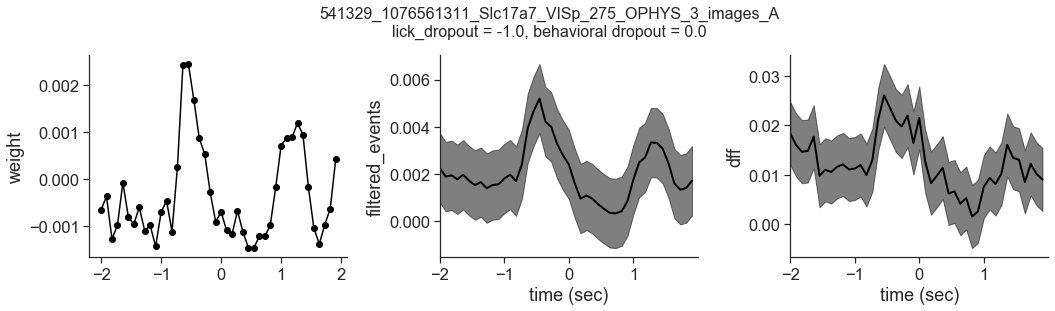

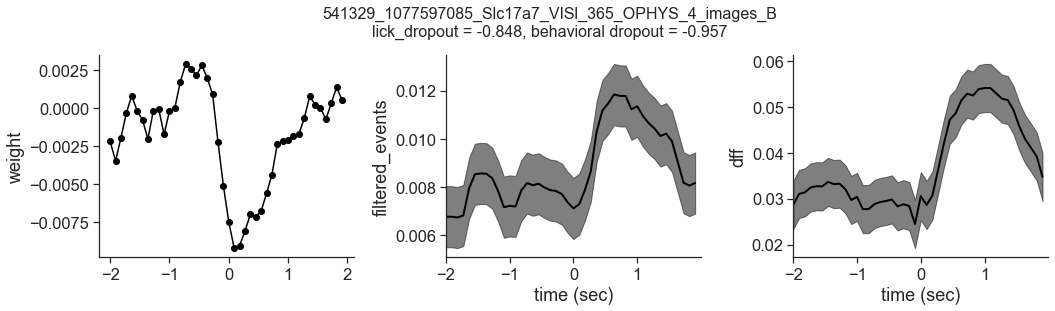

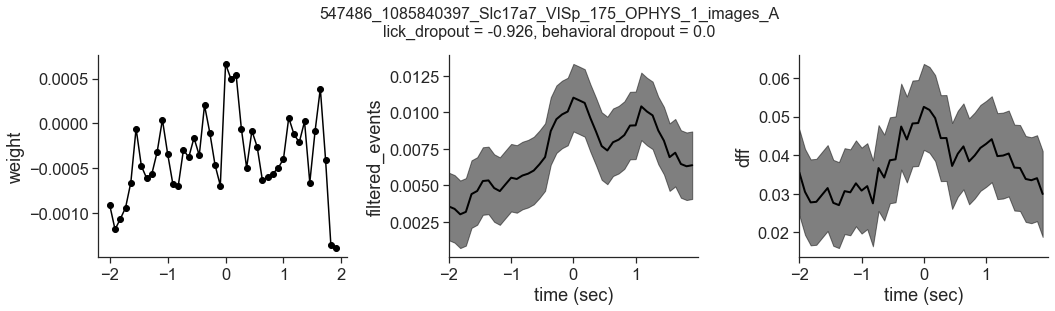

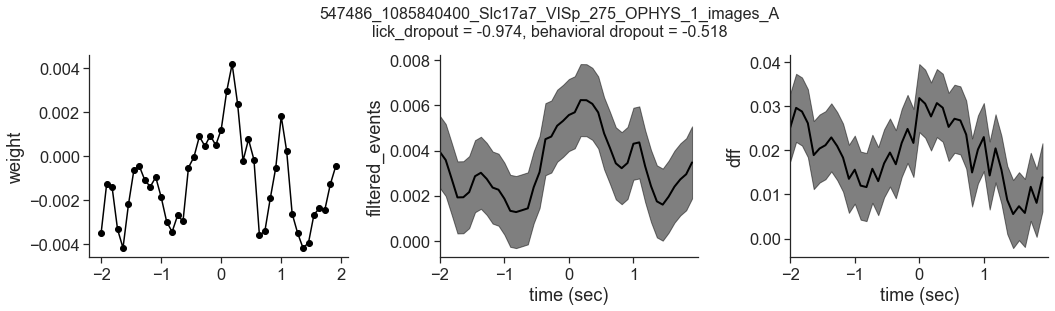

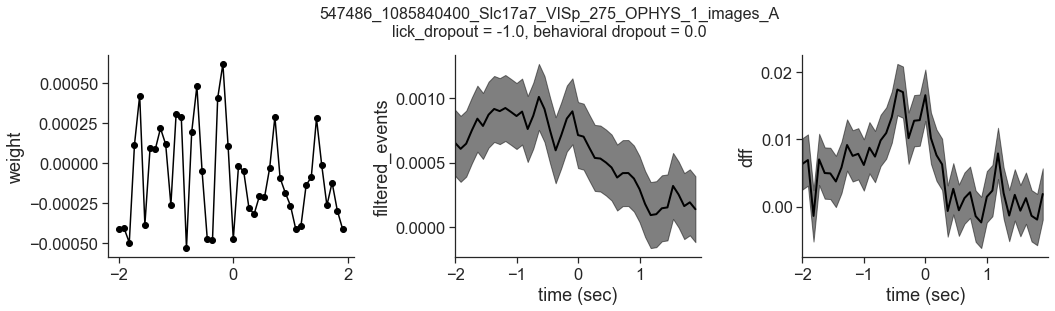

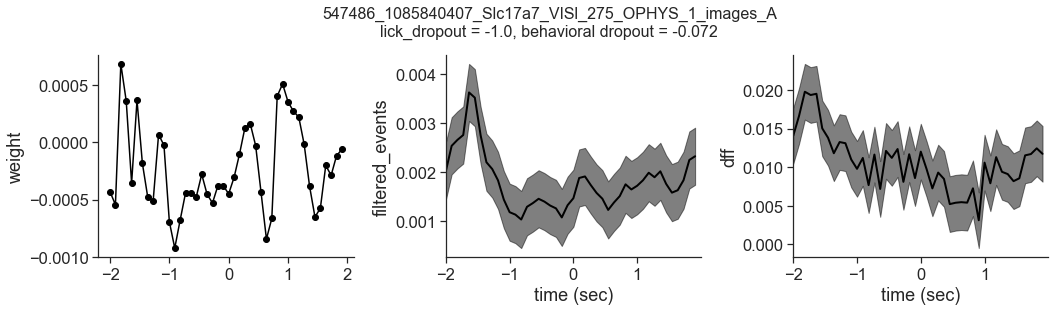

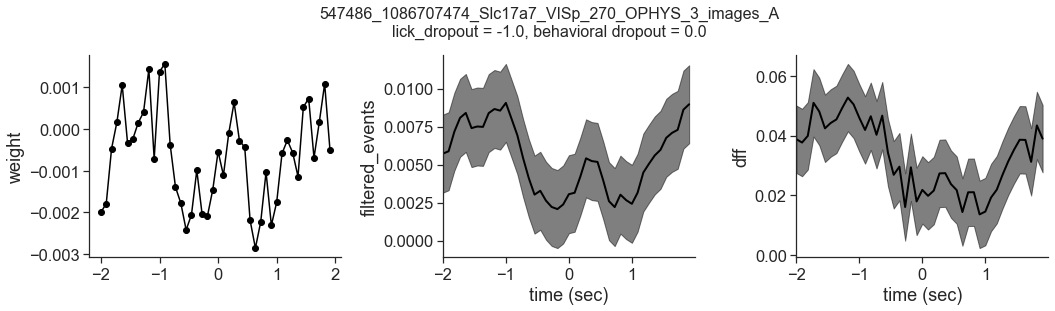

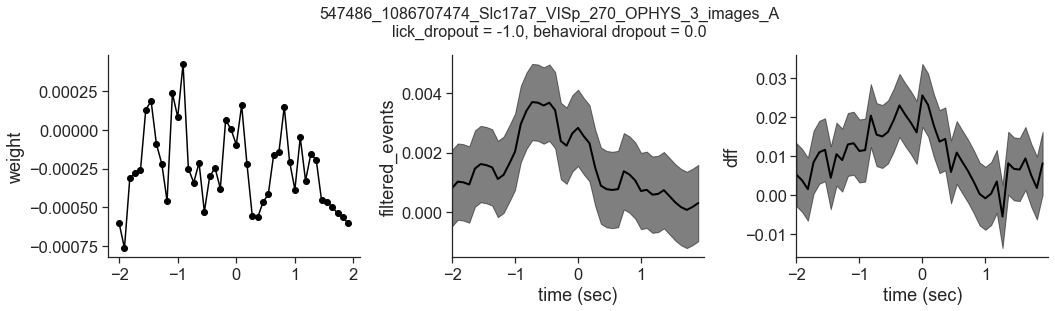

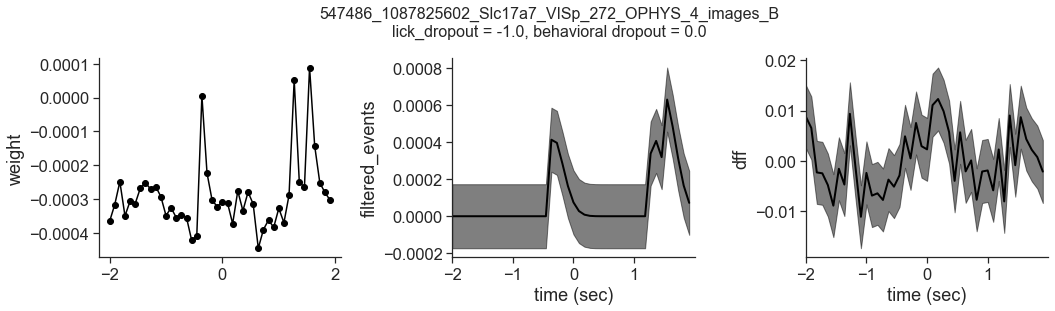

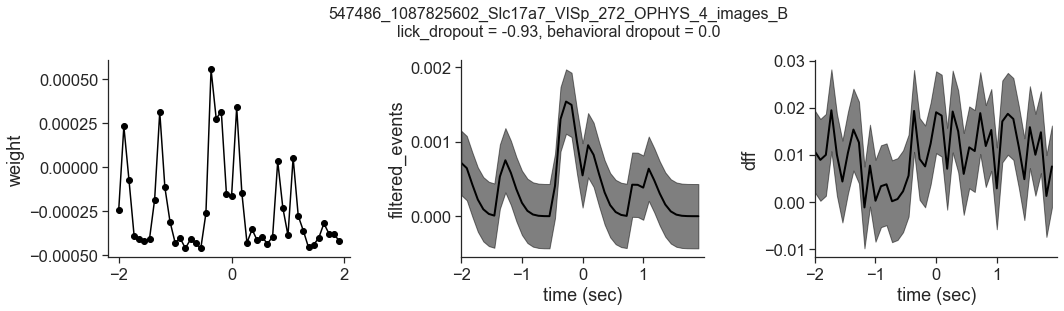

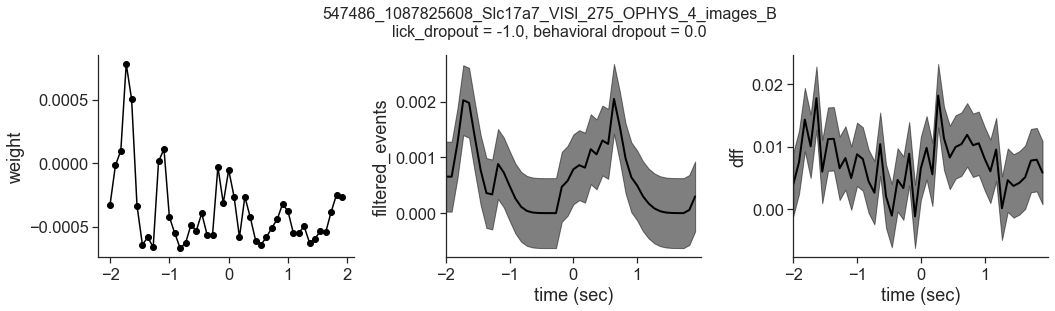

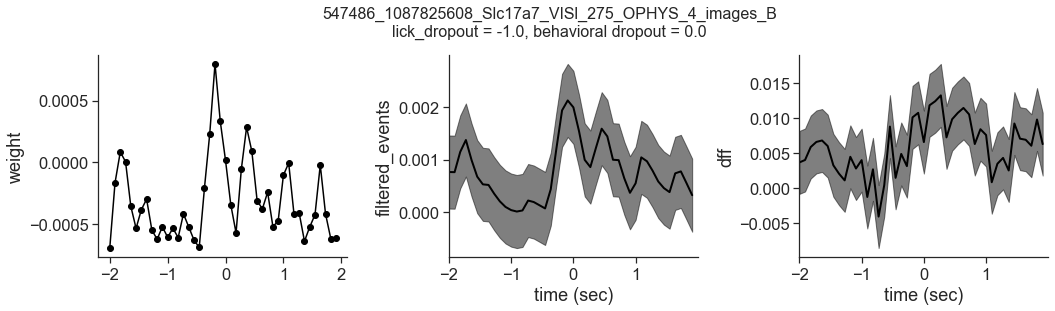

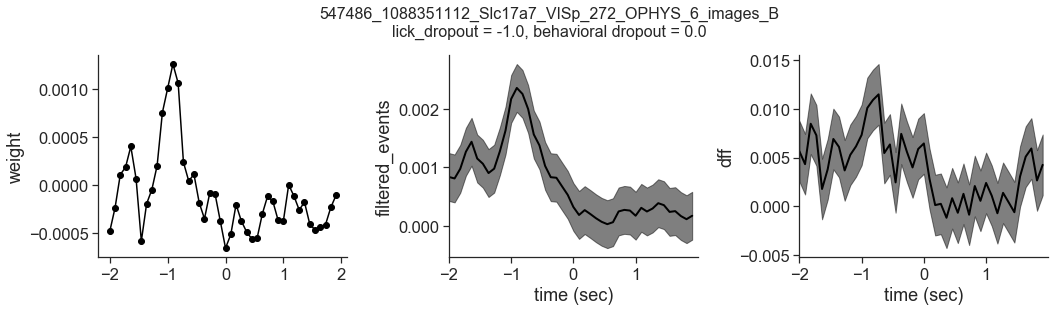

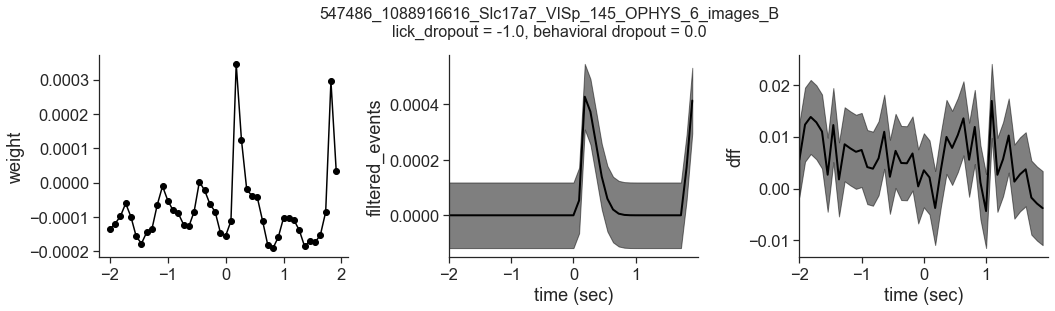

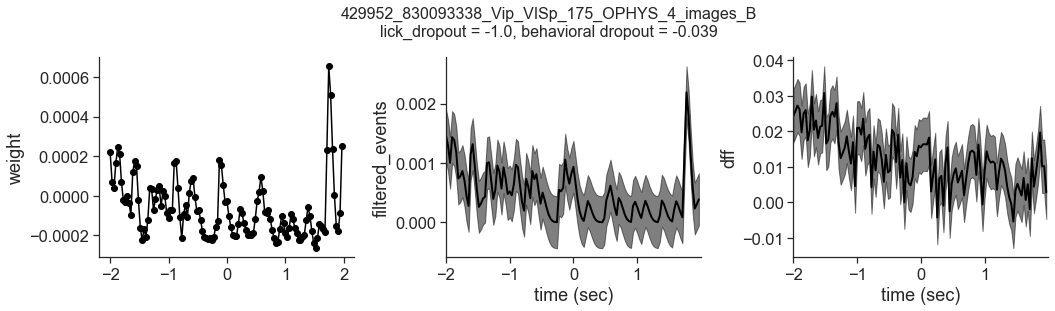

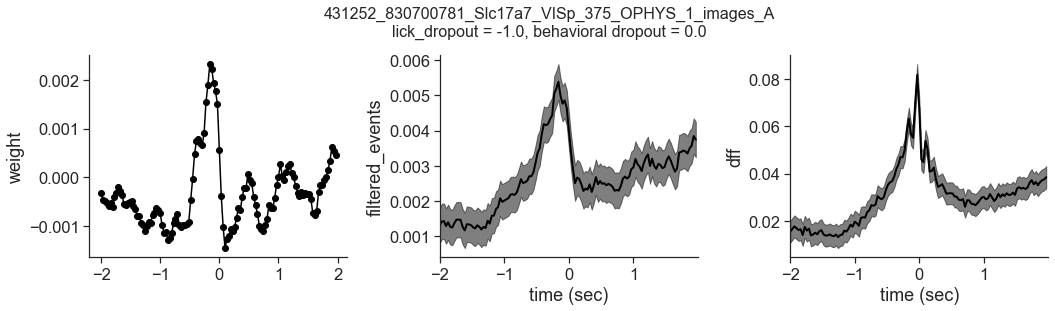

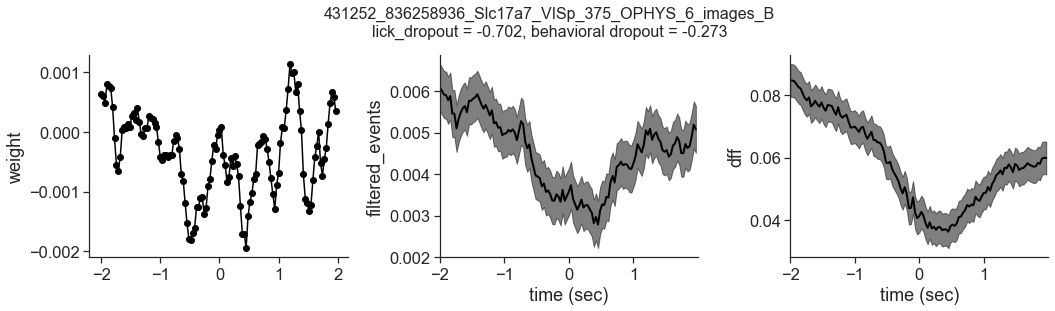

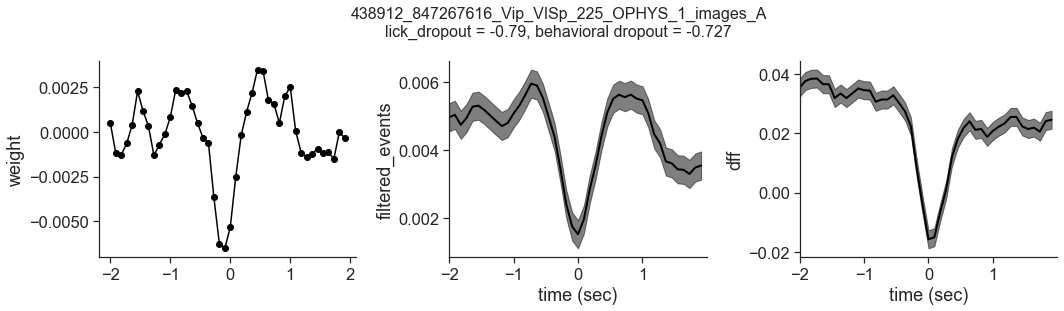

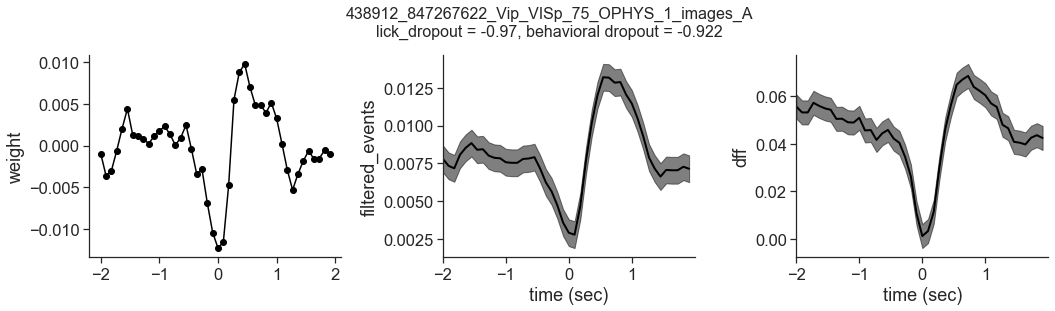

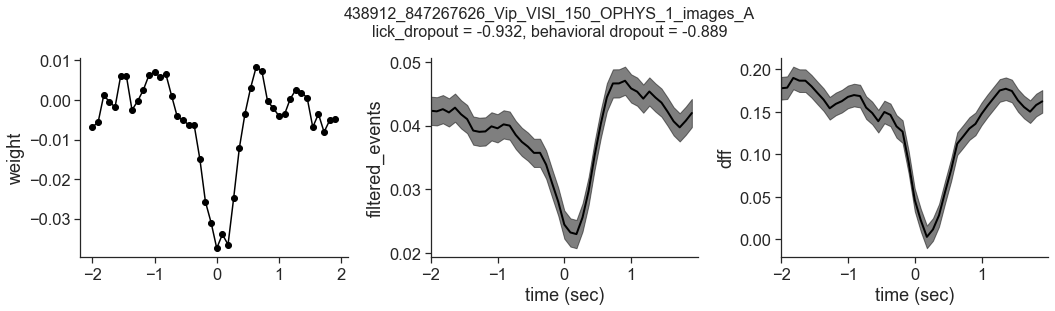

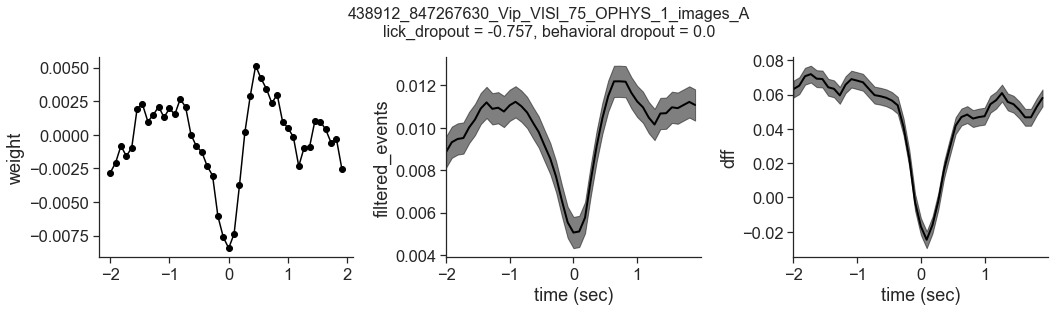

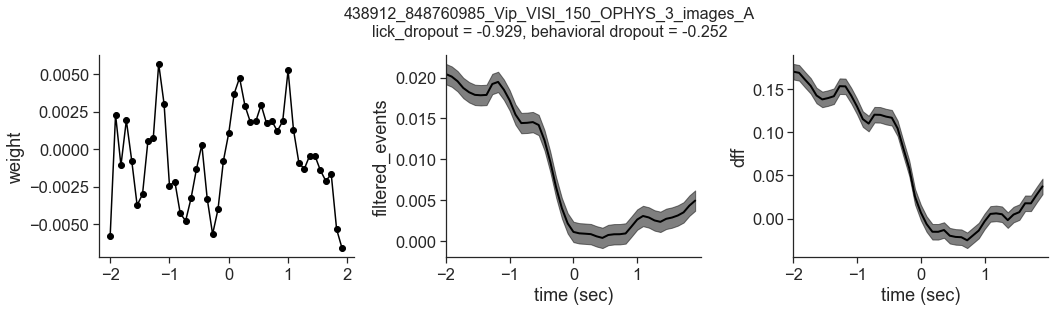

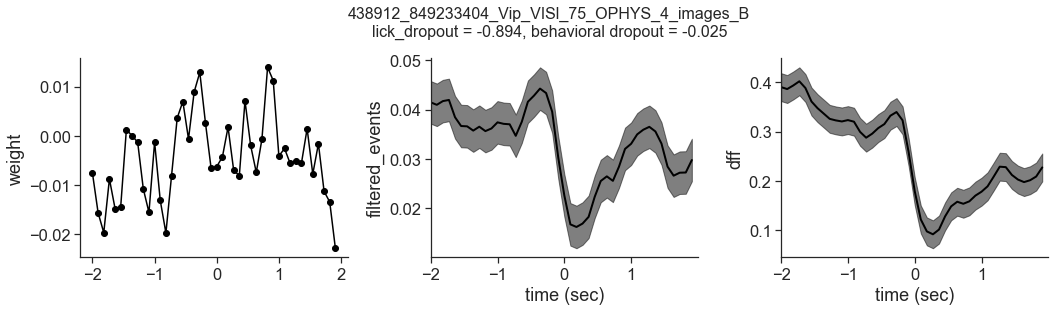

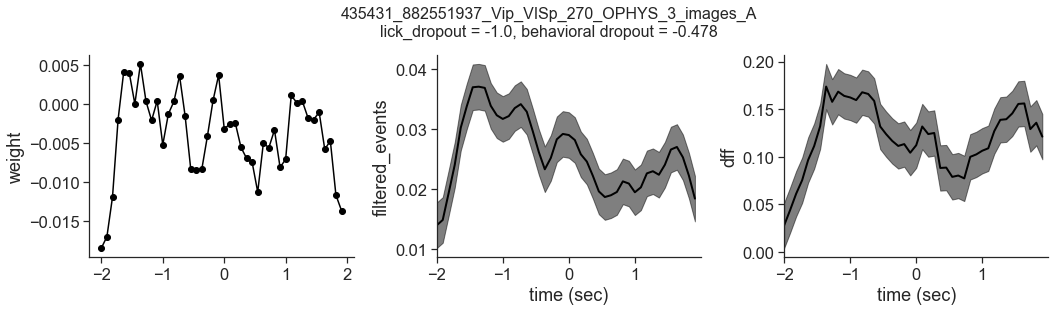

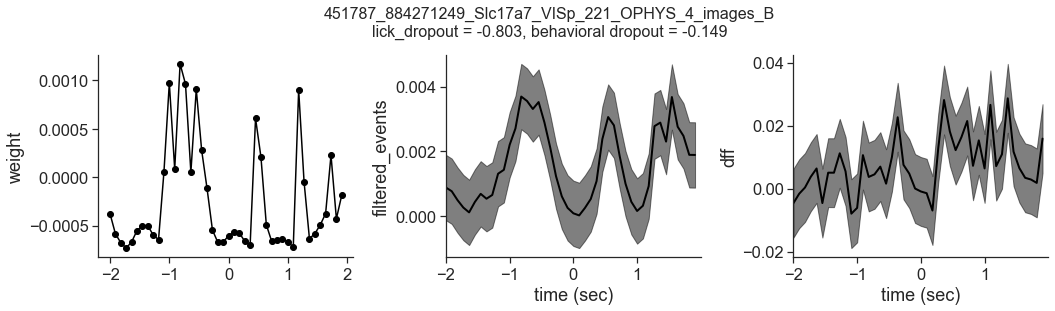

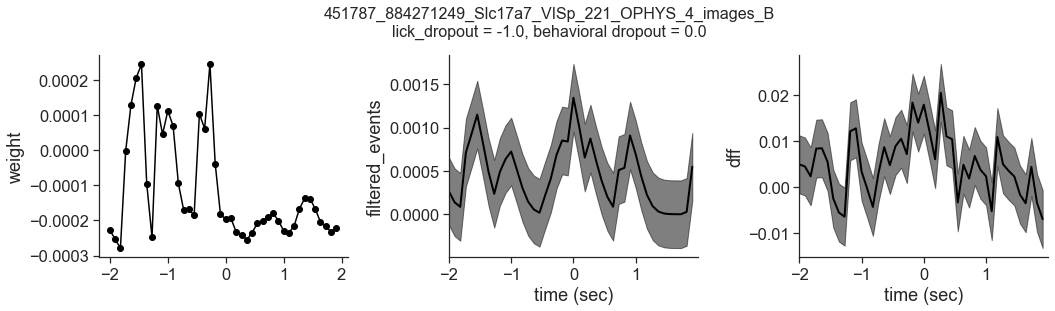

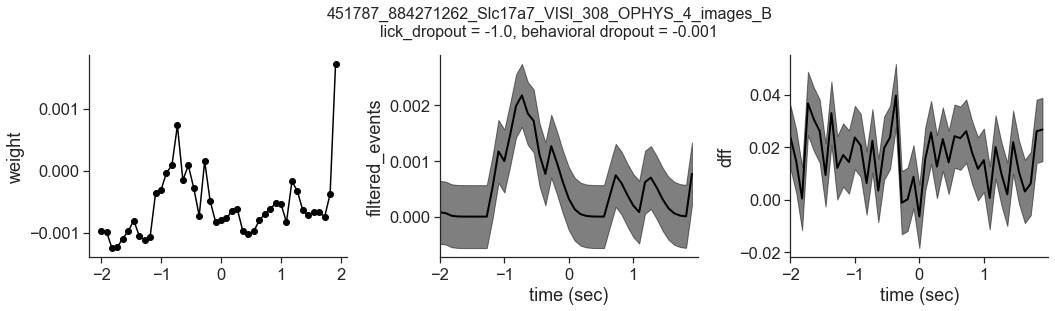

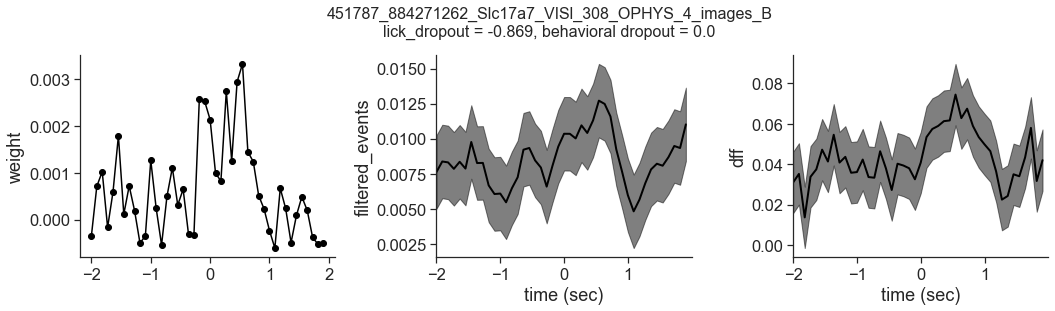

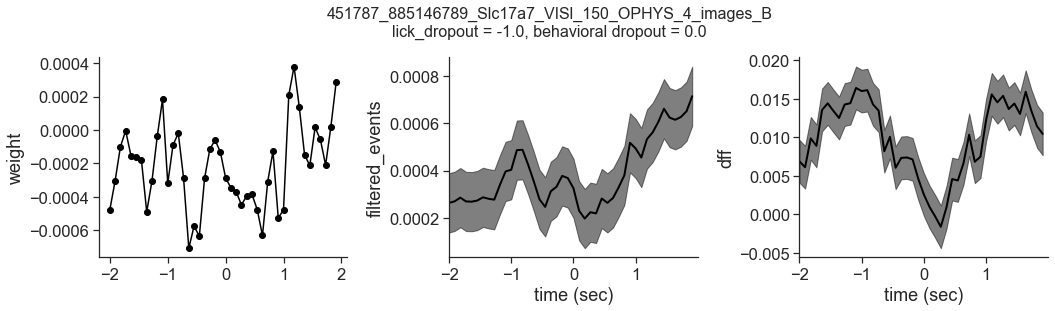

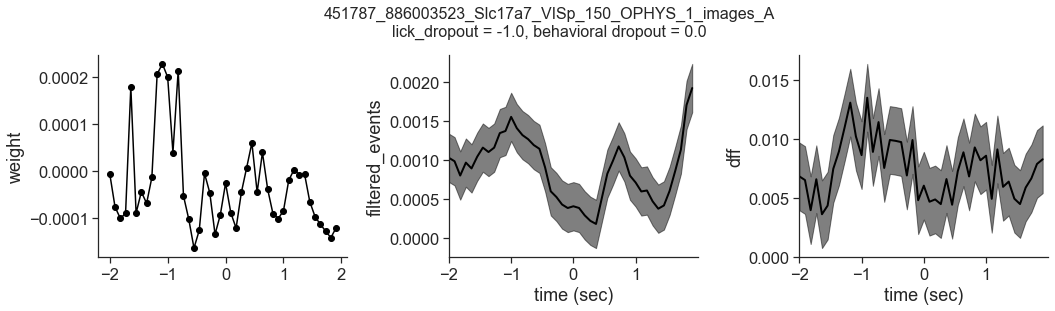

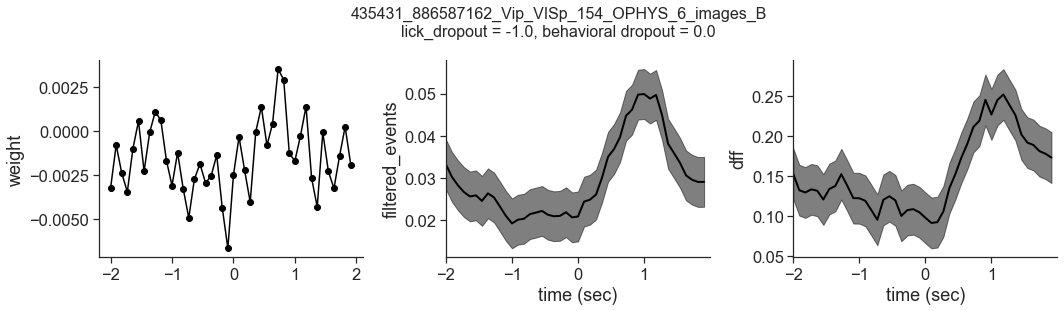

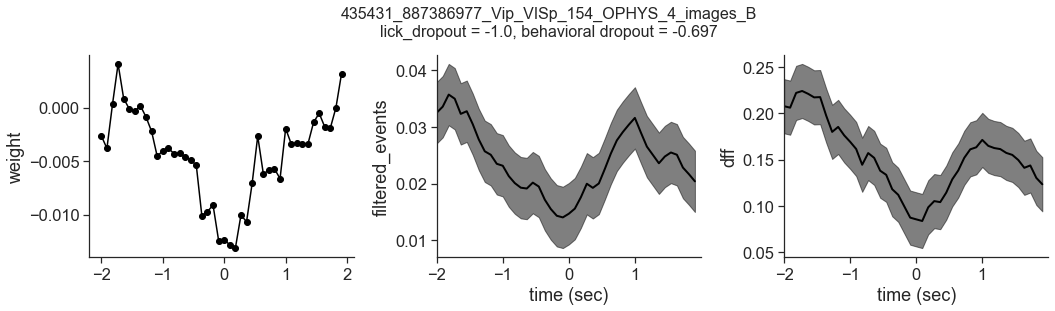

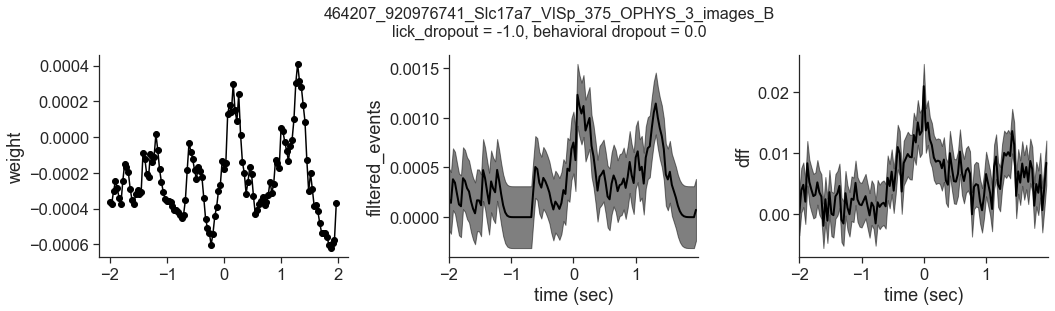

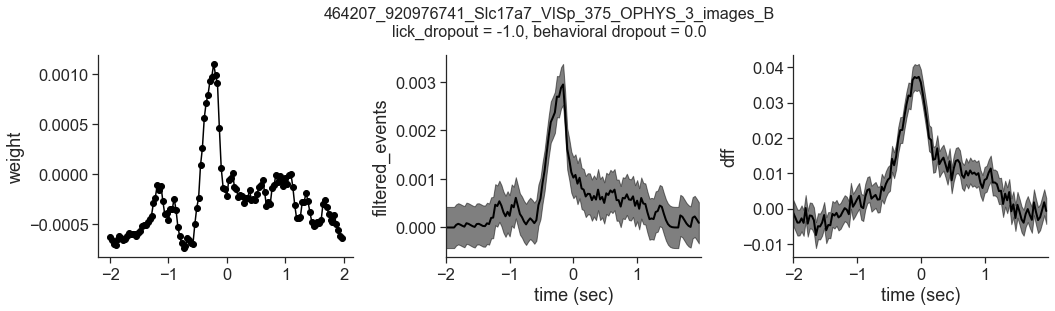

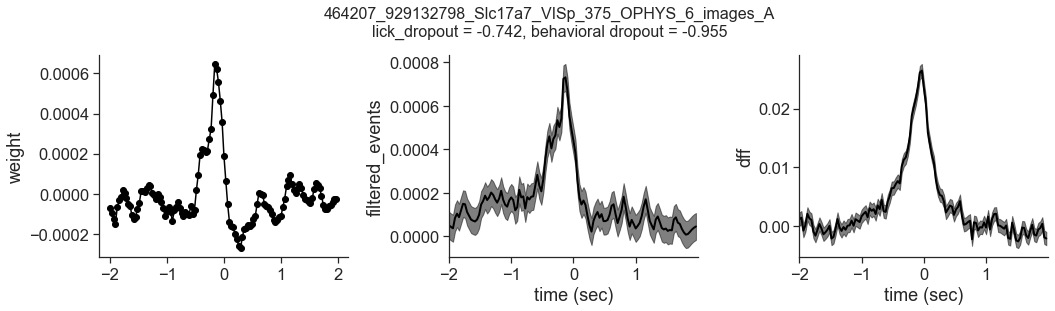

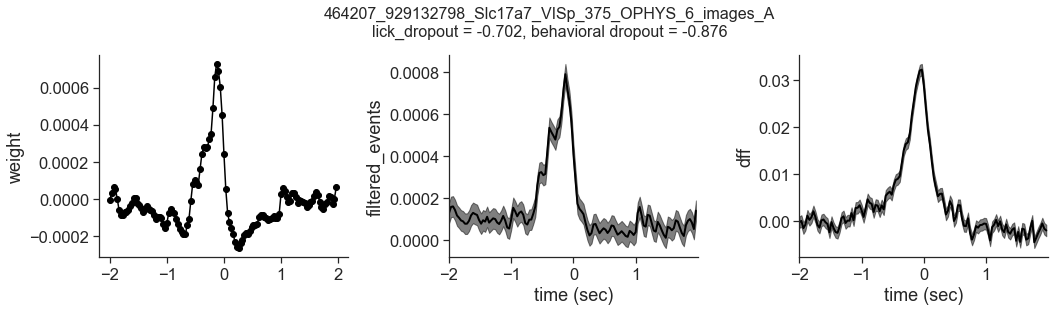

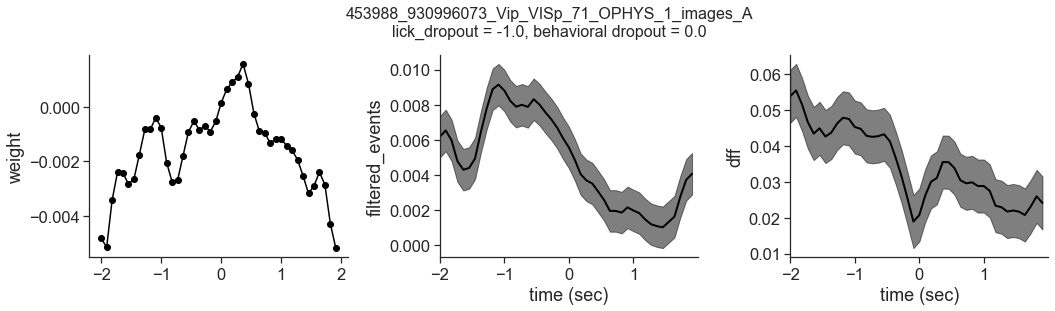

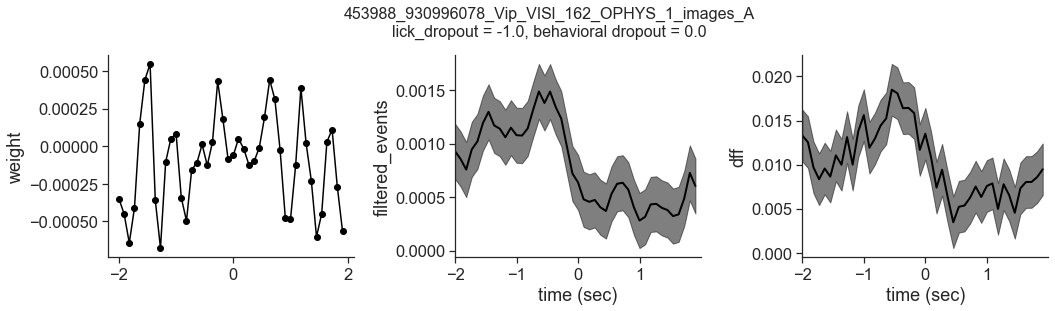

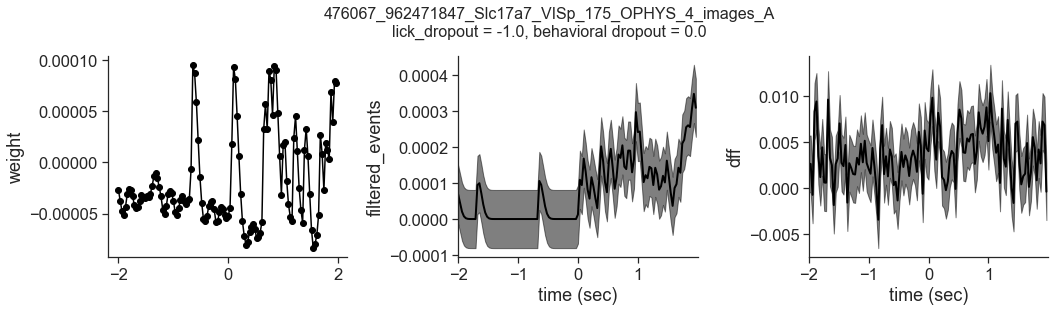

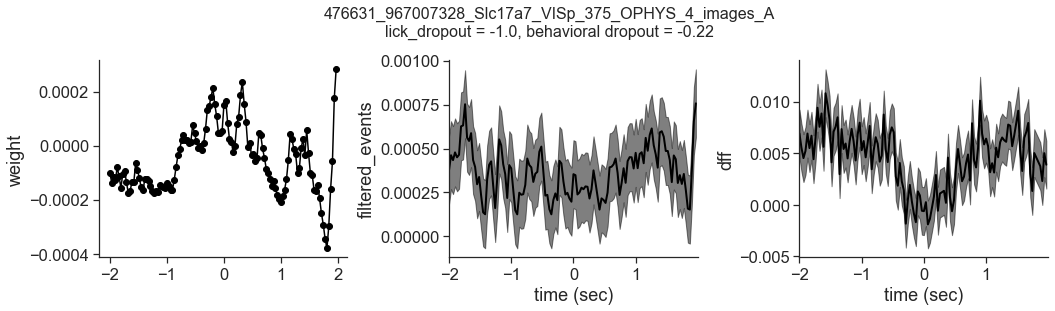

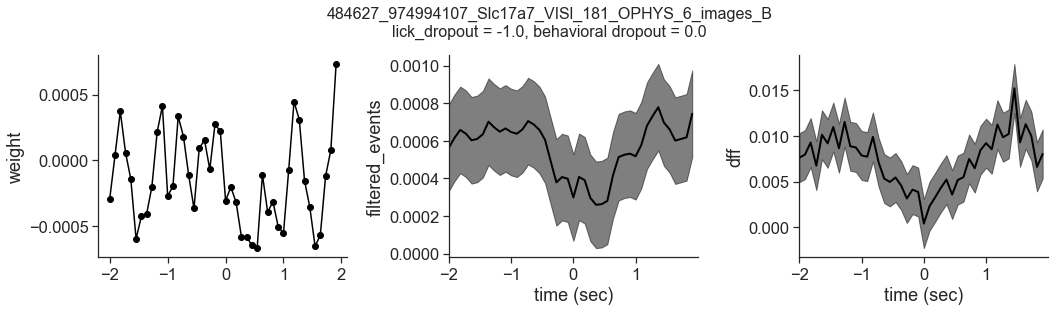

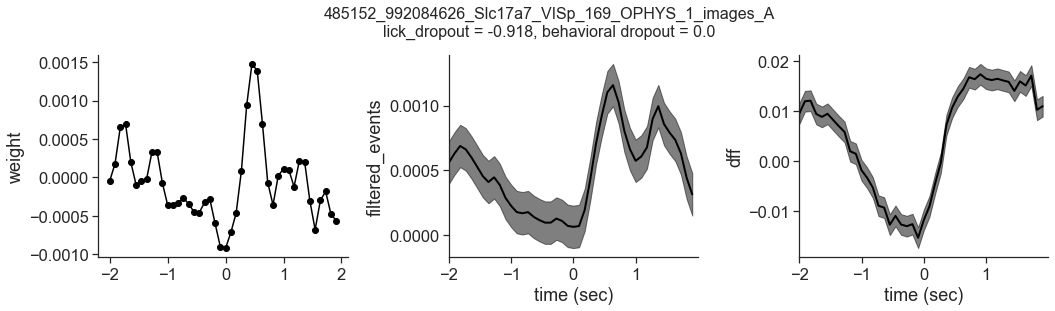

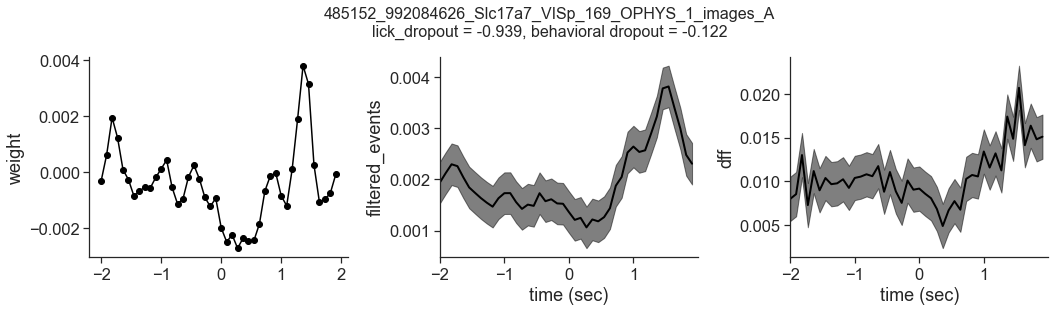

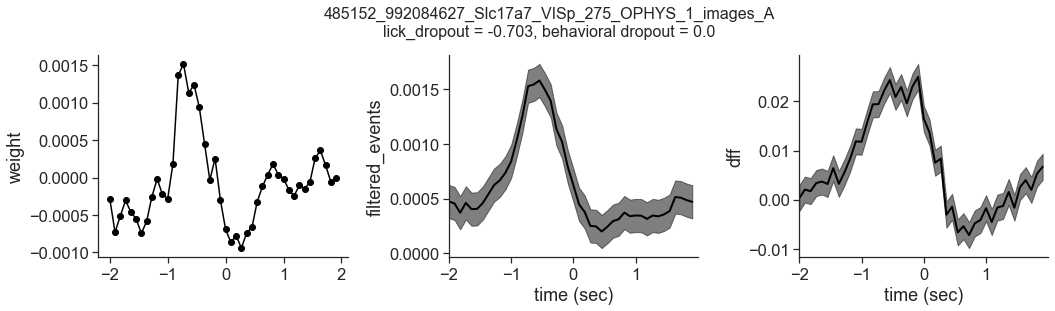

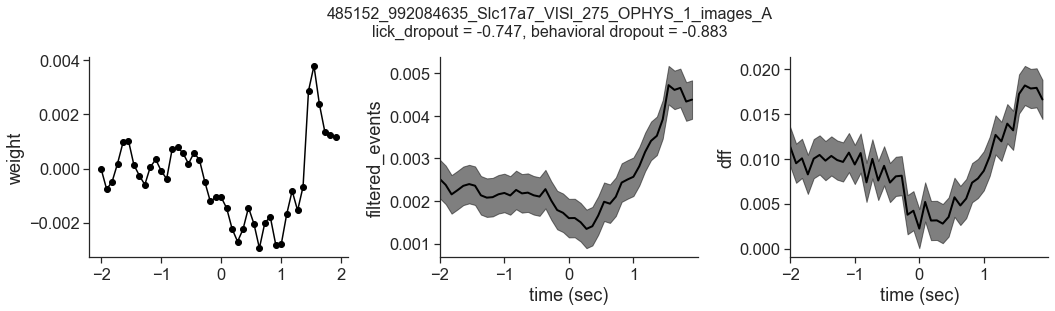

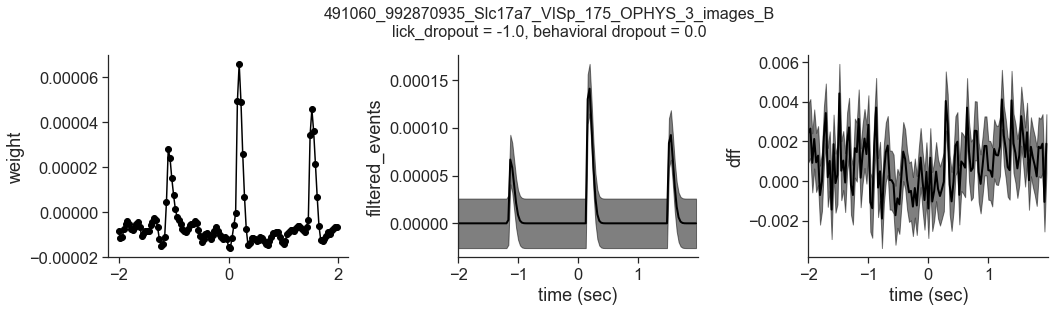

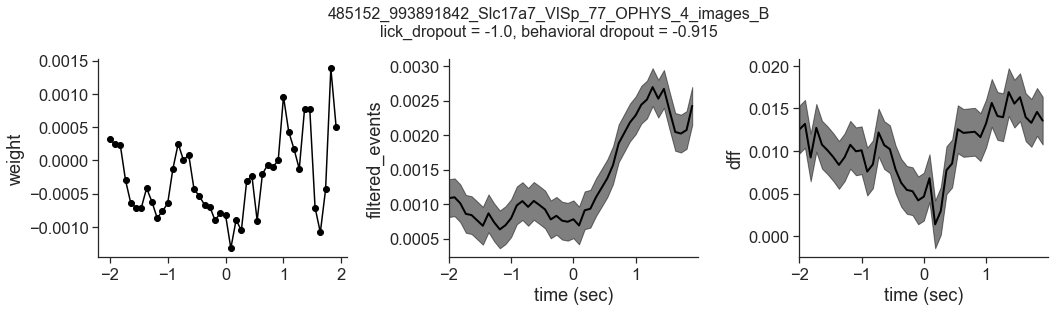

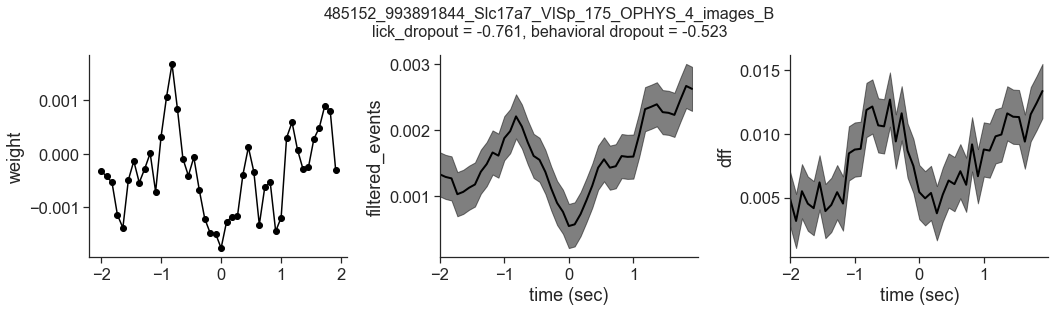

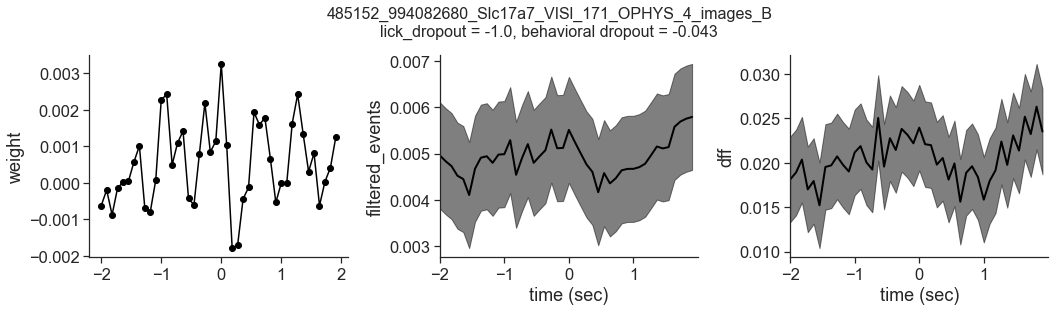

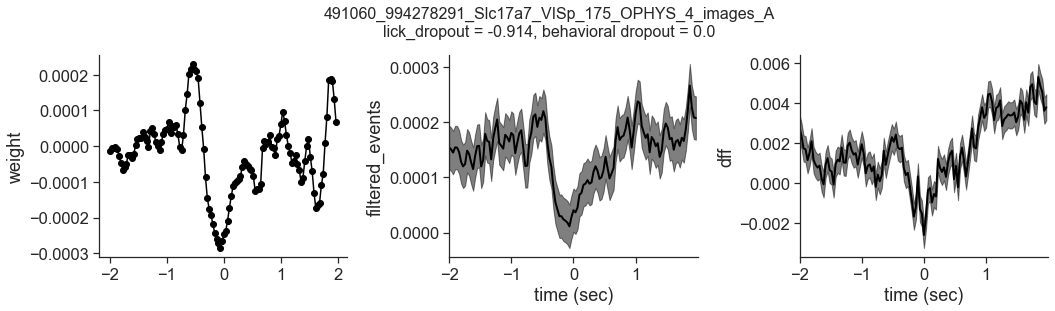

In [46]:
for i in range(len(examples))[2:]:
    example = examples.iloc[i]

    identifier = example.identifier
    print(identifier)
    cell_specimen_id = example.cell_specimen_id
    ophys_experiment_id = example.ophys_experiment_id

    dataset = cache.get_behavior_ophys_experiment(ophys_experiment_id)
    event_times = dataset.licks.timestamps

    if 'MESO' in weights_df.loc[identifier]['equipment_name']:
        frame_rate = 11.
    else:
        frame_rate = 31.

    time_window = (kernels['licks']['offset'], kernels['licks']['offset']+kernels['licks']['length'])
    t_array = ms_utils.get_time_array(t_start=time_window[0], t_end=time_window[1], sampling_rate=frame_rate, include_endpoint=False,)

    figsize=(15,4)
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    ax = ax.ravel()
    ax[0].plot(t_array, weights_df.loc[identifier]['licks_weights'],'ko-')
    ax[0].set_ylabel('weight')

    ax[1] = plot_etr_trace_for_cell_specimen_id(dataset, cell_specimen_id, 'filtered_events', event_times, time_window, frame_rate, ax=ax[1])

    ax[2] = plot_etr_trace_for_cell_specimen_id(dataset, cell_specimen_id, 'dff', event_times, time_window, frame_rate, ax=ax[2])

    lick_dropout = np.round(example.licks, 3)
    behavioral_dropout = np.round(example.behavioral, 3)
    metadata_string = utils.get_metadata_string(dataset.metadata)
    plt.suptitle(metadata_string+'\nlick_dropout = '+str(lick_dropout)+', behavioral dropout = '+str(behavioral_dropout), x=0.52, y=1.1, fontsize=16)
    fig.tight_layout()
    if save_dir: 
        folder = 'lick_kernel'
        filename = str(cell_specimen_id)+'_'+metadata_string+'_licks'
        utils.save_figure(fig, figsize, save_dir, folder, filename)